In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import numpy as np

#data path 수정
os.chdir("C:\\Users\\Owner2\\Desktop\\G팔로미_vuno")
os.getcwd()

'C:\\Users\\Owner2\\Desktop\\G팔로미_vuno'

In [2]:
X=np.load('data_X.npy')
y=np.load('data_y.npy')

In [3]:
#train, validation set 분리
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2)

In [4]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    #featurewise_center=True, #center 중심 유지
    #featurewise_std_normalization=True, #normalization
    rotation_range=25.0,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #brightness_range=[0.2,1.0],
    zoom_range=[0.8,1.2],
    horizontal_flip=True) #수평방향 뒤집기

datagen.fit(X_train)

dgf=datagen.flow(X_train,y_train,batch_size=32)

Using TensorFlow backend.


In [5]:
from keras import models, layers
from keras import Input
from keras.applications import VGG16
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add

model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model.trainable = False
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
for layer in model.layers:
    layer.trainable=False

x=model.output
x=layers.Flatten()(x)
outputs=Dense(4, activation='softmax')(x)

additional_model=Model(inputs=model.input, outputs=outputs)

additional_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [7]:
def f1score(precision, recall):
    _f1score = ( 2 * recall * precision) / (recall + precision)
    
    # return a single tensor value
    return _f1score

In [8]:
# checkpoint = ModelCheckpoint(filepath='My_VGG_{epoch:03d}_{val_loss:.7f}.hdf5',monitor='loss', mode='min', save_best_only=True)
checkpoint = ModelCheckpoint(filepath='VGG16_fine_tuning_그냥.hdf5', 
            monitor='val_acc',
            mode='max', 
            save_best_only=True)

In [9]:
import tensorflow as tf

additional_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['acc',tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

In [10]:
history = additional_model.fit_generator(dgf, 
            steps_per_epoch=len(X_train)/32, 
            epochs=5, 
            validation_data=(X_val,y_val), 
            validation_steps=len(X_val)/32, 
            callbacks=[checkpoint])

Epoch 1/5
43/42 [==============================] - 14s 332ms/step - loss: 1.3663 - acc: 0.2863 - auc: 0.5318 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1score: 0.1030 - val_loss: 1.3757 - val_acc: 0.3149 - val_auc: 0.5673 - val_precision: 0.2500 - val_recall: 5.7872e-04 - val_f1score: 0.1035
Epoch 2/5
43/42 [==============================] - 11s 256ms/step - loss: 1.2758 - acc: 0.3828 - auc: 0.5977 - precision: 0.4140 - recall: 0.0016 - f1score: 0.1105 - val_loss: 1.2906 - val_acc: 0.3761 - val_auc: 0.6280 - val_precision: 0.5974 - val_recall: 0.0027 - val_f1score: 0.1106
Epoch 3/5
43/42 [==============================] - 13s 301ms/step - loss: 1.2250 - acc: 0.4456 - auc: 0.6487 - precision: 0.6849 - recall: 0.0052 - f1score: 0.1154 - val_loss: 1.2742 - val_acc: 0.3557 - val_auc: 0.6640 - val_precision: 0.6555 - val_recall: 0.0114 - val_f1score: 0.1127
Epoch 4/5
43/42 [==============================] - 12s 291ms/step - loss: 1.1742 - acc: 0.4748 - auc: 0.6783 - precision: 0.6511 -

In [11]:
for layer in additional_model.layers[:11]:
    layer.trainable=False

for layer in additional_model.layers[11:]:
    layer.trainable=True

In [12]:
for layer in additional_model.layers:
    print(layer, layer.trainable)
    
additional_model.summary()

<keras.engine.input_layer.InputLayer object at 0x000001B72367CF88> False
<keras.layers.convolutional.Conv2D object at 0x000001B723683948> False
<keras.layers.convolutional.Conv2D object at 0x000001B723683A08> False
<keras.layers.pooling.MaxPooling2D object at 0x000001B75A9C5808> False
<keras.layers.convolutional.Conv2D object at 0x000001B75A9C5BC8> False
<keras.layers.convolutional.Conv2D object at 0x000001B75A9D4B08> False
<keras.layers.pooling.MaxPooling2D object at 0x000001B75A9D4788> False
<keras.layers.convolutional.Conv2D object at 0x000001B75A9D85C8> False
<keras.layers.convolutional.Conv2D object at 0x000001B75A9E4788> False
<keras.layers.convolutional.Conv2D object at 0x000001B75A9E7E88> False
<keras.layers.pooling.MaxPooling2D object at 0x000001B75A9EE688> False
<keras.layers.convolutional.Conv2D object at 0x000001B75AC23408> True
<keras.layers.convolutional.Conv2D object at 0x000001B75AC2AD08> True
<keras.layers.convolutional.Conv2D object at 0x000001B75AC2CAC8> True
<keras.

C:\Users\Owner2\Anaconda3\envs\keras2\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [13]:
import tensorflow as tf

additional_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc',tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

In [14]:
history = additional_model.fit_generator(dgf, 
            steps_per_epoch=len(X_train)/32, 
            epochs=10, 
            validation_data=(X_val,y_val), 
            validation_steps=len(X_val)/32, 
            callbacks=[checkpoint])

Epoch 1/10
43/42 [==============================] - 13s 309ms/step - loss: 1.0280 - acc: 0.5457 - auc_1: 0.8011 - precision_1: 0.6851 - recall_1: 0.2326 - f1score: 0.1383 - val_loss: 1.0015 - val_acc: 0.5423 - val_auc_1: 0.8103 - val_precision_1: 0.6880 - val_recall_1: 0.3036 - val_f1score: 0.1414
Epoch 2/10
43/42 [==============================] - 12s 279ms/step - loss: 0.9275 - acc: 0.5851 - auc_1: 0.8200 - precision_1: 0.6826 - recall_1: 0.3335 - f1score: 0.1496 - val_loss: 1.0902 - val_acc: 0.5219 - val_auc_1: 0.8248 - val_precision_1: 0.6838 - val_recall_1: 0.3662 - val_f1score: 0.1400
Epoch 3/10
43/42 [==============================] - 12s 290ms/step - loss: 0.8814 - acc: 0.6012 - auc_1: 0.8287 - precision_1: 0.6798 - recall_1: 0.3811 - f1score: 0.1544 - val_loss: 0.9788 - val_acc: 0.5190 - val_auc_1: 0.8333 - val_precision_1: 0.6777 - val_recall_1: 0.3955 - val_f1score: 0.1464
Epoch 4/10
43/42 [==============================] - 12s 289ms/step - loss: 0.8745 - acc: 0.6172 - auc_1

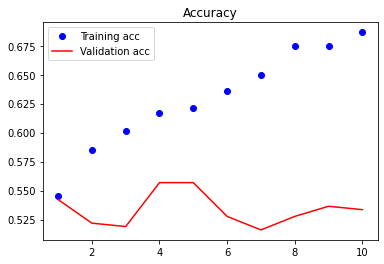

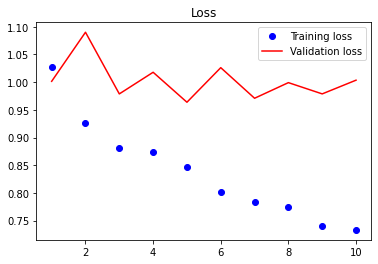

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
 
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
 
plt.show()

In [16]:
for layer in additional_model.layers:
    layer.trainable=True

In [17]:
import tensorflow as tf

additional_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-6),
              metrics=['acc',tf.keras.metrics.AUC(name='auc'),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

history = additional_model.fit_generator(dgf, 
            steps_per_epoch=len(X_train)/32, 
            epochs=37, 
            validation_data=(X_val,y_val), 
            validation_steps=len(X_val)/32, 
            callbacks=[checkpoint])

Epoch 1/37
43/42 [==============================] - 13s 309ms/step - loss: 0.6961 - acc: 0.7005 - auc: 0.9175 - precision_2: 0.7627 - recall_2: 0.6254 - f1score: 0.1741 - val_loss: 0.9550 - val_acc: 0.5598 - val_auc: 0.9049 - val_precision_2: 0.7377 - val_recall_2: 0.6041 - val_f1score: 0.1537
Epoch 2/37
43/42 [==============================] - 12s 278ms/step - loss: 0.6859 - acc: 0.7100 - auc: 0.9054 - precision_2: 0.7374 - recall_2: 0.6052 - f1score: 0.1750 - val_loss: 0.9468 - val_acc: 0.5423 - val_auc: 0.9037 - val_precision_2: 0.7353 - val_recall_2: 0.5995 - val_f1score: 0.1538
Epoch 3/37
43/42 [==============================] - 12s 284ms/step - loss: 0.6583 - acc: 0.7290 - auc: 0.9057 - precision_2: 0.7396 - recall_2: 0.6036 - f1score: 0.1774 - val_loss: 0.9488 - val_acc: 0.5539 - val_auc: 0.9055 - val_precision_2: 0.7386 - val_recall_2: 0.6030 - val_f1score: 0.1542
Epoch 4/37
43/42 [==============================] - 12s 289ms/step - loss: 0.6750 - acc: 0.7180 - auc: 0.9057 - pre

Epoch 29/37
43/42 [==============================] - 12s 286ms/step - loss: 0.6150 - acc: 0.7341 - auc: 0.9105 - precision_2: 0.7416 - recall_2: 0.6297 - f1score: 0.1833 - val_loss: 1.0076 - val_acc: 0.5510 - val_auc: 0.9105 - val_precision_2: 0.7414 - val_recall_2: 0.6298 - val_f1score: 0.1536
Epoch 30/37
43/42 [==============================] - 12s 286ms/step - loss: 0.6089 - acc: 0.7473 - auc: 0.9107 - precision_2: 0.7418 - recall_2: 0.6303 - f1score: 0.1837 - val_loss: 1.0068 - val_acc: 0.5510 - val_auc: 0.9107 - val_precision_2: 0.7417 - val_recall_2: 0.6305 - val_f1score: 0.1545
Epoch 31/37
43/42 [==============================] - 13s 301ms/step - loss: 0.5985 - acc: 0.7495 - auc: 0.9108 - precision_2: 0.7418 - recall_2: 0.6309 - f1score: 0.1844 - val_loss: 1.0021 - val_acc: 0.5364 - val_auc: 0.9109 - val_precision_2: 0.7417 - val_recall_2: 0.6311 - val_f1score: 0.1537
Epoch 32/37
43/42 [==============================] - 13s 295ms/step - loss: 0.5958 - acc: 0.7560 - auc: 0.9110 -

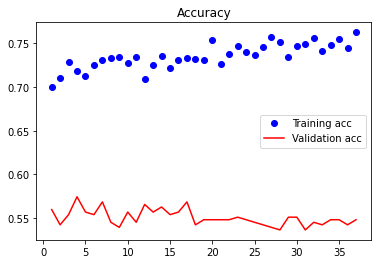

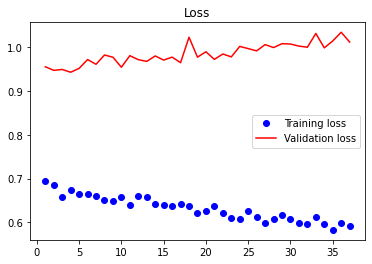

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
 
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
 
plt.show()

In [19]:
_loss, _acc, _auc, _precision, _recall, _f1score = additional_model.evaluate(X_val, y_val, batch_size=32)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

343/343 [==============================] - 1s 3ms/step
loss: 1.011, accuracy: 0.548, auc: 0.912, precision: 0.742, recall: 0.634, f1score: 0.154


In [20]:
from sklearn.metrics import roc_auc_score

y_pred = additional_model.predict(X_val)
roc_auc_score(y_val, y_pred)

0.8376713656493868

In [21]:
import tensorflow as tf

new_model = models.load_model('VGG16_fine_tuning_그냥.hdf5',compile=False)

new_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['acc',tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

In [22]:
_loss, _acc, _auc, _precision, _recall, _f1score =new_model.evaluate(X_val, y_val, batch_size=32)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

343/343 [==============================] - 1s 3ms/step
loss: 0.942, accuracy: 0.574, auc: 0.820, precision: 0.559, recall: 0.431, f1score: 0.155


In [23]:
X_test=np.load('X_val.npy')
y_test=np.load('y_val.npy')

In [25]:
_loss, _acc, _auc, _precision, _recall, _f1score =new_model.evaluate(X_test, y_test, batch_size=32)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

571/571 [==============================] - 2s 3ms/step
loss: 0.831, accuracy: 0.620, auc: 0.863, precision: 0.649, recall: 0.543, f1score: 0.164
